In [64]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import math

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, r2_score
from sklearn import utils, svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
warnings.filterwarnings('ignore') # ignore warnings

## Read and Clean Dataset

In [7]:
df_raw

,date,text,userid_str,status_id_str,id,name,birth,term_partisanship,term_type,term_state,country,Bucket,SentimentScore,version
0,2015-09-28,I commend all of law enforcement for the secur...,156333623.0,6.485341e+17,3517566,Al Green,1947-09-01,Democrat,rep,TX,China,2 or 3,NaN,2019_batch1
1,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,TN,China,1,2.0,2019_batch1
2,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,TN,Iran,2 or 3,NaN,2019_batch1
3,2014-06-24,Inhofe: The Canadians have already had convers...,20546536.0,4.815273e+17,3468157,James M. Inhofe,1934-11-17,Republican,sen,OK,Canada,2 or 3,NaN,2019_batch1
4,2015-07-14,Statement on Iran nuclear agreement. http://t....,18773159.0,6.210401e+17,3833428,Scott Perry,1962-05-27,Republican,rep,PA,Iran,2 or 3,NaN,2019_batch1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15841,2020-10-02,Is it fair to make the assessment that China h...,NaN,NaN,1312023398147649537,Mark Walker,NaN,NaN,{rep},{NC},China,1.0,2.0,NaN
15842,2020-10-07,"American citizen @BobFu4China, who has been a ...",NaN,NaN,1313958758075322368,Marco Rubio,NaN,NaN,{sen},{FL},China,1.0,2.0,NaN
15843,2020-10-06,The inclusion of those products in #GSP would ...,NaN,NaN,1313491844282683395,Albio Sires,NaN,NaN,{rep},{NJ},China,NaN,NaN,NaN
15844,2020-10-07,Join me THURSDAY at 9:00 AM CT on Facebook LIV...,NaN,NaN,1313689442935361536,J. French Hill,NaN,NaN,{rep},{AR},China,2 or 3,NaN,NaN


In [8]:
df_raw = pd.read_csv('SentimentLabeled_10112022.csv')
df = df_raw.drop_duplicates()

# remove {} from columns
df['term_partisanship'] = df['term_partisanship'].str.strip('{}')
df['term_type'] = df['term_type'].str.strip('{}')
df['term_state'] = df['term_type'].str.strip('{}')

# Clean bucket column
df['Bucket'] = df['Bucket'].replace({'1.0':'1', '2.0':'2', '3.0':'3'})

# filter out rows with abonormal sentiment score
df = df[(df['SentimentScore'] <= 5) | (df['SentimentScore'].isnull())]

df.head()

,date,text,userid_str,status_id_str,id,name,birth,term_partisanship,term_type,term_state,country,Bucket,SentimentScore,version
0,2015-09-28,I commend all of law enforcement for the secur...,156333623.0,6.485341e+17,3517566,Al Green,1947-09-01,Democrat,rep,rep,China,2 or 3,NaN,2019_batch1
1,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,rep,China,1,2.0,2019_batch1
2,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,rep,Iran,2 or 3,NaN,2019_batch1
3,2014-06-24,Inhofe: The Canadians have already had convers...,20546536.0,4.815273e+17,3468157,James M. Inhofe,1934-11-17,Republican,sen,sen,Canada,2 or 3,NaN,2019_batch1
4,2015-07-14,Statement on Iran nuclear agreement. http://t....,18773159.0,6.210401e+17,3833428,Scott Perry,1962-05-27,Republican,rep,rep,Iran,2 or 3,NaN,2019_batch1


## Feature Engineering

In [9]:
texts = df[(df['country'] == 'China') & (df['SentimentScore'].isnull() == False)]
avg_score = texts.groupby('id')['SentimentScore'].mean().to_frame().reset_index()
texts = texts.drop_duplicates(subset='id')
texts = texts.drop('SentimentScore', axis=1)
texts = texts.merge(avg_score, on='id', how='left')

In [10]:
feat1 = texts['text'].to_frame()
feat1['SentimentScore'] = texts['SentimentScore']

In [11]:
text_tokenized = feat1['text'].apply(word_tokenize) #tokenize each tweet
tagged_text = [TaggedDocument(d,[i]) for i, d in enumerate(text_tokenized)] #tag sentence corpus
d2v_model = Doc2Vec(tagged_text, vector_size=30, window=2, min_count=1, epochs=100) #train Doc2Vec model

feat1['text_vector'] = text_tokenized.apply(d2v_model.infer_vector) # convert text to vectors
feat1['text_vector'] = feat1['text_vector'].apply(lambda x: list(x))
feat1[list(range(1,31))] = pd.DataFrame(feat1['text_vector'].tolist(), index= feat1.index)

In [12]:
feat2 = texts['text'].to_frame()
feat2['SentimentScore'] = texts['SentimentScore'] # target column: Sentiment Score

feat2['text'] = feat2['text'].str.lower() 
feat2["text"] = feat2['text'].str.replace('[^\w\s]','')

## Train Test Split

In [13]:
training1, testing1 = train_test_split(feat1, test_size=0.25, random_state=25)
training2, testing2 = train_test_split(feat2, test_size=0.25, random_state=25)

In [14]:
train_y = training1['SentimentScore']
train_X = training1.drop(['text', 'text_vector', 'SentimentScore'], axis = 1)
train_X1 = training2['text']
test_y = testing1['SentimentScore']
test_X = testing1.drop(['text', 'text_vector', 'SentimentScore'], axis = 1)
test_X1 = testing2['text']

## Ridge

In [15]:
### using doc2vec
ridge = Ridge(alpha=1.0, solver='sag').fit(train_X, train_y)

In [16]:
pred_ridge = ridge.predict(test_X)
mean_squared_error(test_y, pred_ridge)

0.34115460909417894

In [57]:
r2_score(test_y, pred_ridge)

0.10000458563738102

In [17]:
### using tfidf
stopword = stopwords.words('english')

pipe_ridge = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('ridge', Ridge(alpha=1.0))])
pipe_ridge.fit(train_X1, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('ridge', Ridge())])

In [18]:
pred_ridge1 = pipe_ridge.predict(test_X1)
mean_squared_error(test_y, pred_ridge1)

0.26513636470725827

In [46]:
r2_score(test_y, pred_ridge1)

0.3005473000910457

In [19]:
# ridge_param = {
#     'ridge__alpha': [0.1, 1, 10, 100],
#     'ridge__solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
# }

In [20]:
# # GridSearch
# grid_ridge = GridSearchCV(pipe_ridge, ridge_param, refit = True, verbose = 3)
# grid_ridge.fit(train_X1, train_y)

Best parameters: {'ridge__alpha': 1, 'ridge__solver': 'sag'}

In [21]:
pipe_ridge_tuned = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('ridge', Ridge(alpha=1.0, solver='sag'))])
pipe_ridge_tuned.fit(train_X1, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('ridge', Ridge(solver='sag'))])

In [22]:
pred_ridge2 = pipe_ridge_tuned.predict(test_X1)
mean_squared_error(test_y, pred_ridge2)

0.26512777900678264

In [47]:
r2_score(test_y, pred_ridge2)

0.30056994991271346

In [60]:
np.std(test_y), np.std(pred_ridge2)

(0.615680605633454, 0.39010740466809274)

(array([[4.30e+01, 0.00e+00, 7.95e+02, 4.00e+02, 9.46e+02, 4.00e+00,
         2.80e+01, 1.00e+00, 3.50e+01, 5.00e+00],
        [3.00e+00, 1.33e+02, 8.22e+02, 1.07e+03, 2.04e+02, 1.30e+01,
         2.00e+00, 8.00e+00, 2.00e+00, 0.00e+00]]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 2 BarContainer objects>)

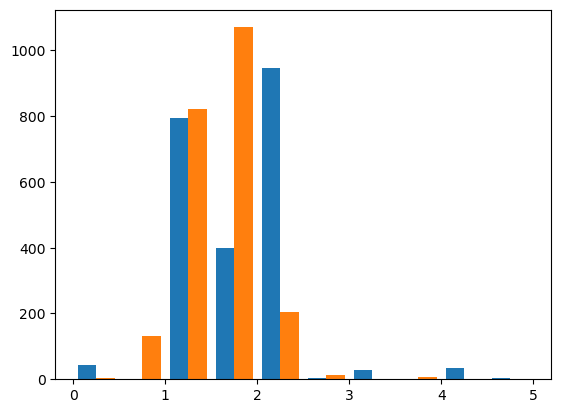

In [61]:
plt.hist([test_y, pred_ridge2])

## Lasso

In [23]:
lasso = Lasso(alpha=1.0).fit(train_X, train_y)

In [24]:
pred_lasso = lasso.predict(test_X)
mean_squared_error(test_y, pred_lasso)

0.3791576198729482

In [25]:
pipe_lasso = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('lasso', Lasso(alpha=1.0))])
pipe_lasso.fit(train_X1, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lasso', Lasso())])

In [26]:
pred_lasso1 = pipe_lasso.predict(test_X1)
mean_squared_error(test_y, pred_lasso1)

0.379157620980874

## Decision Tree

In [27]:
dtr = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=20,
    min_samples_leaf=5,
    random_state=0).fit(train_X, train_y)
pred_dtr = dtr.predict(test_X)
mean_squared_error(test_y, pred_dtr)

0.5768110910929596

In [48]:
r2_score(test_y, pred_dtr)

-0.5216776297278531

In [28]:
pipe_dt = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('dt', DecisionTreeRegressor(random_state=0))])
pipe_dt.fit(train_X1, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('dt', DecisionTreeRegressor(random_state=0))])

In [29]:
pred_dt1 = pipe_dt.predict(test_X1)
mean_squared_error(test_y, pred_dt1)

0.5190795303500222

In [30]:
pipe_dt.get_params(deep=True)

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                               'ourselves', 'you', "you're", "you've", "you'll",
                               "you'd", 'your', 'yours', 'yourself', 'yourselves',
                               'he', 'him', 'his', 'himself', 'she', "she's",
                               'her', 'hers', 'herself', 'it', "it's", 'its',
                               'itself', ...])),
  ('dt', DecisionTreeRegressor(random_state=0))],
 'verbose': False,
 'tfidf': TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                             'ourselves', 'you', "you're", "you've", "you'll",
                             "you'd", 'your', 'yours', 'yourself', 'yourselves',
                             'he', 'him', 'his', 'himself', 'she', "she's",
                             'her', 'hers', 'herself', 'it', "it's", 'its',
                             'itself', ...]),
 

In [31]:
# # GridSearch
# dt_param = {
#     'dt__criterion':['squared_error', 'friedman_mse', 'poisson'],
#     'dt__max_depth':[1, 5, 10, 15, 20],
#     'dt__min_samples_leaf': range(1,6)
# }
# dt_grid = GridSearchCV(pipe_dt, dt_param, verbose = 3)
# dt_grid.fit(train_X1, train_y)

{'dt__criterion': 'squared_error', 'dt__max_depth': 20, 'dt__min_samples_leaf': 5}

In [32]:
# print(dt_grid.best_params_)

In [33]:
# pipe_dt_tuned = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words = stopword)),
#     ('dt', DecisionTreeRegressor(
#         criterion='squared_error',
#         max_depth=20,
#         min_samples_leaf=5,
#         random_state=0))])
# pipe_dt_tuned.fit(train_X1, train_y)

In [38]:
pipe_dt_tuned = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('dt', DecisionTreeRegressor(
        criterion='squared_error',
        max_depth=20,
        min_samples_leaf=5,
        random_state=0))])
pipe_dt_tuned.fit(train_X1, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('dt',
                 DecisionTreeRegressor(max_depth=20, min_samples_leaf=5,
                                       random_state=0))])

In [39]:
pred_dt2 = pipe_dt_tuned.predict(test_X1)
mean_squared_error(test_y, pred_dt2)

0.337073322758161

In [49]:
r2_score(test_y, pred_dt2)

0.11077137256976266

## Random Forest

In [52]:
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('rf', RandomForestRegressor(random_state=0))])
pipe_rf.fit(train_X1, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf', RandomForestRegressor(random_state=0))])

In [53]:
pred_rf = pipe_rf.predict(test_X1)
mean_squared_error(test_y, pred_rf)

0.27436954382661355

In [54]:
r2_score(test_y, pred_rf)

0.27618937366738594

{'rf__criterion': 'poisson', 'rf__max_depth': 20, 'rf__min_samples_leaf': 1}

In [ ]:
# pipe_rf_tuned = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words = stopword)),
#     ('rf', RandomForestRegressor(
#         criterion='poisson',
#         max_depth=25,
#         min_samples_leaf=1,
#         min_samples_split=5,
#         random_state=0))])
# pipe_rf_tuned.fit(train_X1, train_y)

In [55]:
rf = RandomForestRegressor(
    criterion='poisson',
    max_depth=25,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=0).fit(train_X, train_y)
pred_rf1 = rf.predict(test_X)

0.27436954382661355

In [58]:
mean_squared_error(test_y, pred_rf1)

0.33329619487001055

In [56]:
r2_score(test_y, pred_rf1)

0.12073576316622125